# Hydrocode

Written June 2024

Purely Lagragian 1D hydrocode from scratch without consulting the internet. Only the textbooks that I've been given.

In [282]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

### Initialize a state (with a pressure gradient)

Let $s_j^n$ be a state vector. $j$ increments space in one dimension and $n$ increments the time step

---

$[s_0^0, s_1^0, s_2^0, s_3^0, ...] \rightarrow \text{space}$ 

$[s_0^1, s_1^1, s_2^1, s_3^1, ...]$

$[s_0^2, s_1^2, s_2^2, s_3^2, ...]$

$\downarrow \text{time}$

--- 



In [283]:
# zones = LEN - 1
LEN = 10 # num of nodes
M = 1 # in grams, mass within each cell remains constant
V = 1 # in L
GAMMA = 1.4

# defined at mesh points
x = np.linspace(0, LEN-1, LEN)
velocity = np.full(LEN, 0, dtype="float64")

# defined at zone center
e_int = np.full(LEN-1, 1) # Joules
e_int[0] = 40
mass_vector = np.full(LEN-1, M)
mass_vector[0] = 40
density = mass_vector / np.diff(x)

# derived from eos
pressure = (GAMMA - 1) * density * e_int


In the Colvin and Larsen book (12.1.2), we talk about stability of the momentum equation in any finite difference scheme. This prevents our plots from exploding

$\Delta t = \alpha \left( \frac{\Delta x}{c_s} \right)_{min}$

$\alpha = 0.95$

This is the Courant-Friedrichs-Lewy criterion.

In [284]:
def get_delta_time(pressure, x, density):
    # must obey the CFL condition
    # < (dx/cs)_min
    zone_x = 0.5 * np.array([x[i] + x[i+1]  for i in range(LEN-1)])
    node_pressures = 0.5 * np.array([pressure[i] + pressure[i+1] for i in range(LEN-2)])
    node_pressures = np.hstack([pressure[0], node_pressures, pressure[LEN-2]])

    # at each zone / cell
    c_sound = np.sqrt( GAMMA / density ) * - zone_x * np.diff(node_pressures) / np.diff(x)

    # clean this data for errors
    if np.isnan(c_sound).any():
        print(c_sound)
        raise RuntimeError("Contains nan")

    if np.isinf(c_sound).any():
        print(c_sound)
        raise RuntimeError("Contains inf")

    dt = np.diff(x) / c_sound
    non_negative_dt = dt[np.greater(dt, np.zeros(len(dt)))]

    if len(non_negative_dt) > 0:
        delta_t = 0.99 * np.min(non_negative_dt)
        return delta_t

    print(dt)
    raise RuntimeError("Unexpected error")

get_delta_time(pressure, x, density)

C:\Users\hu31\AppData\Local\Temp\ipykernel_39136\3583179235.py:20: RuntimeWarning: divide by zero encountered in divide
  dt = np.diff(x) / c_sound


0.001744220788370297

In [285]:
# nodes
pd.DataFrame(np.stack([x, velocity]))

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [286]:
# zones
pd.DataFrame(np.stack([e_int, density, pressure]))

,0,1,2,3,4,5,6,7,8
0,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,640.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4


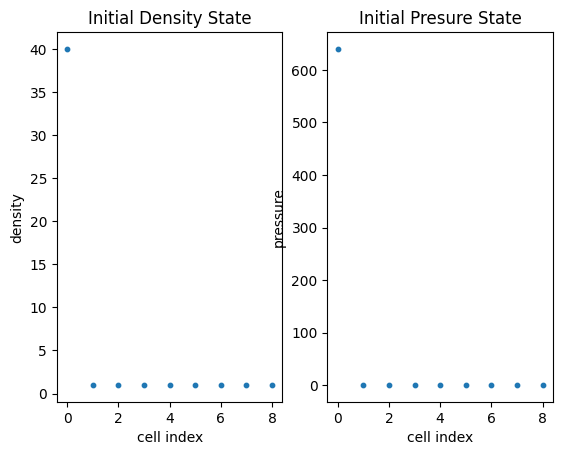

In [287]:
ax = plt.subplot(121)

ax.set_title("Initial Density State")
ax.set_ylabel("density")
ax.set_xlabel("cell index")

ax.scatter(np.arange(LEN-1), density, LEN)

ax2 = plt.subplot(122)

ax2.set_title("Initial Presure State")
ax2.set_ylabel("pressure")
ax2.set_xlabel("cell index")

ax2.scatter(np.arange(LEN-1), pressure, LEN)

plt.show()

### Transition into next state

Using finite difference equations (Richtmyer/Morton 1.3, Colvin/Larsen 11.4)

(Colvin/Larsen 12.1-4):

#### Things we'll need to update:

$ P = (\gamma - 1) \rho \epsilon$

$x_j^{n+1} = x_j^n + u_j^{n + 1/2} \Delta t^{n + 1/2}$

For Lagrangian, mass is conserved within each zone, so we derive density:

$\rho_{j+1/2}^n = \frac{ m_{j+1/2} }{ x_{j+1}^n - x_j^n}$



> Lagragian so use vorticity equation, derivation in notebook

Using the equation of momentum, we can derive the velocity:

$ F_{tot} = F_{inner} + F_{surf}$ for arbitrary enclosed shape

$ \frac{D}{Dt} \int_V \rho \textbf{u} \quad dV = \int_V \rho \textbf{f} \quad dV - \oint \textbf{P} \cdot \textbf{dA} $

$\rho \frac{D u}{D t} =  \rho \textbf{f} - \nabla P $

$\rho \left( \frac{\partial}{\partial t} + \textbf{u} \cdot \nabla \right) \textbf{u} = - \nabla P \quad$ Assuming no external forces

$\rho \frac{\partial \textbf{u}}{\partial t} = - \frac{ \partial P}{\partial x} $
$ \quad \quad \leftarrow \nabla \cdot \textbf{u} = 0$ incompressible

$\frac{1}{2} \left( \rho_{j + 1/2}^n + \rho_{j-1/2}^n \right) \frac{u_j^{n + 1/2} - u_j^{n-1/2}}{\Delta t^n} = - \frac{P_{j+1/2}^n - P_{j+1/2}^n}{ x_{j+1/2} - x_{j-1/2} } $
$ \quad \quad$  $j+1/2$ suggests a zone center

$u_j^{n + 1/2} - u_j^{n-1/2} = \Delta u_j^n = - \frac{\Delta t^n}{\frac{1}{2} \left( \rho_{j + 1/2}^n + \rho_{j-1/2}^n \right) } \frac{P_{j+1/2}^n - P_{j+1/2}^n}{ x_{j+1/2} - x_{j-1/2} } $

$u_j^{n+1} = u_j^n + \Delta u_j^n$


Using the equation of energy, derive internal energy:

$\rho \frac{D \epsilon}{D t} = - P \nabla \cdot \textbf{u}$

$\rho \left( \frac{\partial}{\partial t} + \textbf{u} \cdot \nabla \right) \epsilon = - P \nabla \cdot \textbf{u}$

$\rho \frac{\partial \epsilon}{\partial t} = - P \nabla \cdot \textbf{u} \quad \quad \leftarrow \nabla \cdot \epsilon =0\quad$ local minima/maxima

$\rho_{j+1/2}^n \frac{\epsilon_{j+1/2}^{n+1/2} - \epsilon_{j+1/2}^{n-1/2} }{\Delta t^n} = - P_{j+1/2}^n \cdot \frac{ u_{j+1}^{n} - u_{j}^{n} }{ x_{j+1} - x_{j} }$

$ \epsilon_{j+1/2}^{n+1/2} - \epsilon_{j+1/2}^{n-1/2} = \Delta \epsilon_{j+1/2}^n = - P_{j+1/2}^n \cdot \frac{ \Delta t^n }{ \rho_{j+1/2}^n } \cdot \frac{ u_{j+1}^{n} - u_{j}^{n} }{ x_{j+1} - x_{j} }$

$\epsilon_{j+1/2}^{n+1} = \epsilon_{j+1/2}^n + \Delta \epsilon_{j+1/2}^n$


Shock waves are mathematically described as a discontinuity. Hence, our conservation equations don't apply. To make our conservation waves work, we need to pretend the wave of some thickness where some particles are colliding with each other. Applying a conservation equations to the shock wave will mean some kinetic energy transforms to heat, which is viscous dissipation. 

We will use the quadratic von Neumann artificial viscosity

$ Q \sim \rho ( \Delta x )^2 \left( \frac{\partial u}{\partial x} \right)^2 $

Just add this to the thermodynamic pressure of a zone


In [288]:
TIME_LEN = 3000
K = 0.2

X = np.array([x])
time = np.stack([np.arange(LEN) for _ in range(TIME_LEN)])
density_vector = np.array([density.copy()])
pressure_vector = np.array([pressure.copy()])
q_vector = np.ones(LEN - 1 )


for i in range(TIME_LEN-1):

    # update timestep for next iteration
    dt = get_delta_time(pressure, x, density)
    print(dt)

    # nodal (excluding edges)
    node_densities = 0.5 * np.array([density[i] + density[i+1] for i in range(LEN-2)])
    # zonal
    zone_x = 0.5 * np.array([x[i] + x[i+1]  for i in range(LEN-1)])

    # zonal
    e_int = e_int - pressure * dt * np.diff(velocity) / ( density * np.diff(x) )

    # boundary condition here - first and last nodes don't move
    velocity[1:LEN-1] -= np.array(dt * np.diff(pressure) / ( node_densities * np.diff(zone_x) ))
    
    x = x + velocity * dt

    density = mass_vector / np.diff(x)

    # equation of state
    p_eos = (GAMMA - 1) * density * e_int

    # pseudoviscocity
    du = np.diff(velocity)
    dx = np.diff(x)
    tmp = du*du / (dx *dx)
    q = K * density * tmp

    pressure = p_eos + q

    q_vector = np.vstack((q_vector, q.copy()))

    X = np.vstack((X, x.copy()))
    density_vector = np.vstack((density_vector, density.copy()))
    pressure_vector = np.vstack((pressure_vector, pressure.copy()))

pd.DataFrame(q_vector)

C:\Users\hu31\AppData\Local\Temp\ipykernel_39136\3583179235.py:20: RuntimeWarning: divide by zero encountered in divide
  dt = np.diff(x) / c_sound


0.001744220788370297
0.0017440183212441853
0.0017436151761693094
0.001743011666790832
0.001742208286687246
0.0017412057074206197
0.001740004775899078
0.0017386065110735003
0.001737012099995764
0.0017352228932708054
0.0017332403999393835
0.0017310662818325689
0.0017287023474425289
0.0017261505453573822
0.0017234129573103136
0.001720491790895155
0.001717389372001992
0.0017141081370271012
0.001710650624911779
0.0017070194690642416
0.0017032173892179206
0.0016992471832780783
0.0016951117192068683
0.0016908139269947156
0.0016863567907632333
0.0016817433410420237
0.0016769766472584555
0.0016720598104761006
0.0016669959564139338
0.0016617882287746715
0.001656439782906868
0.0016509537798215785
0.0016453333805806173
0.0016395817410697288
0.0016337020071663633
0.0016276973103082407
0.0016215707634655656
0.0016153254575165738
0.001608964458023137
0.0016024908024003916
0.0015959074974718453
0.0015892175173991055
0.0015824238019733173
0.0015755292552535939
0.001568536744536135
0.0015614490996363713

,0,1,2,3,4,5,6,7,8
0,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00
1,0.023685,0.000592,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
2,0.094679,0.002371,2.417802e-13,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
3,0.212816,0.005338,5.959561e-12,3.579463e-25,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
4,0.377835,0.009498,4.645361e-11,1.942701e-23,4.793260e-37,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...
2995,0.602630,324834.072054,2.322611e+04,1.357434e+01,1.391218e+02,91.255310,50.295668,0.193301,7.036097e-07
2996,0.601719,325164.292081,2.325738e+04,1.381146e+01,1.391130e+02,91.256135,50.296075,0.193304,7.036353e-07
2997,0.600809,325494.616894,2.328867e+04,1.405069e+01,1.391042e+02,91.256960,50.296481,0.193308,7.036608e-07
2998,0.599900,325825.046434,2.331998e+04,1.429205e+01,1.390954e+02,91.257783,50.296887,0.193312,7.036863e-07


In [289]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0
1,0.0,1.000095,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0
2,0.0,1.000285,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0
3,0.0,1.000569,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0
4,0.0,1.000949,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0
...,...,...,...,...,...,...,...,...,...,...
2995,0.0,5.481247,5.627116,5.949752,6.074098,6.200933,6.406079,7.017103,8.000018,9.0
2996,0.0,5.481247,5.627129,5.949754,6.074100,6.200935,6.406080,7.017103,8.000018,9.0
2997,0.0,5.481248,5.627141,5.949756,6.074102,6.200937,6.406082,7.017103,8.000018,9.0
2998,0.0,5.481249,5.627154,5.949758,6.074104,6.200939,6.406083,7.017103,8.000018,9.0


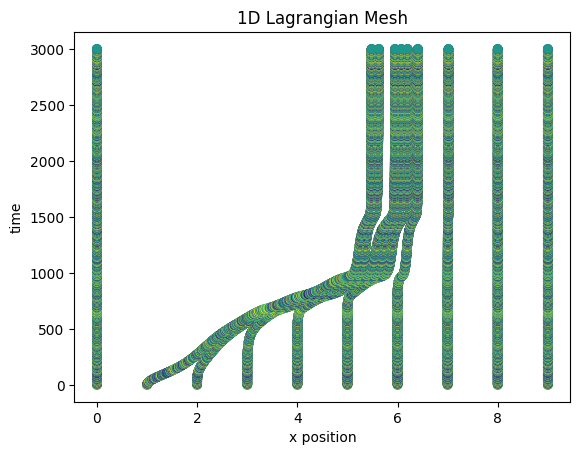

In [290]:
fig, ax = plt.subplots()

ax.set_title("1D Lagrangian Mesh")
ax.set_xlabel("x position")
ax.set_ylabel("time")

colors = np.repeat(np.random.uniform(15, 80, TIME_LEN), LEN)

ax.scatter(X.flatten(), np.repeat(np.arange(TIME_LEN), LEN), c=colors)

plt.show()

In [291]:
pd.DataFrame(density_vector)

,0,1,2,3,4,5,6,7,8
0,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,39.996204,1.000095,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,39.988614,1.000285,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,39.977239,1.000570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,39.962088,1.000950,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
2995,7.297610,6.855445,3.099474,8.042060,7.884220,4.874593,1.636597,1.017382,1.000018
2996,7.297609,6.854886,3.099575,8.042064,7.884232,4.874601,1.636601,1.017382,1.000018
2997,7.297608,6.854327,3.099675,8.042068,7.884244,4.874609,1.636604,1.017382,1.000018
2998,7.297607,6.853769,3.099776,8.042072,7.884257,4.874617,1.636607,1.017382,1.000018


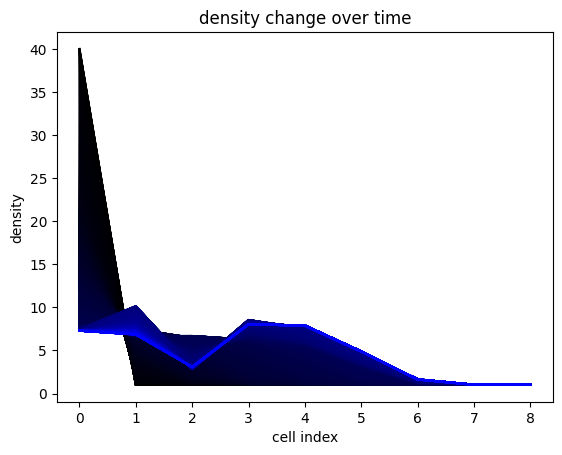

In [292]:
fig, ax = plt.subplots()

ax.set_xlabel("cell index")
ax.set_ylabel("density")
ax.set_title("density change over time")

for i, vec in enumerate(density_vector):
    ax.plot(np.arange(LEN-1), vec, LEN, alpha=0.6, c=(0, 0, i / len(density_vector)))

plt.show()

In [67]:
pd.DataFrame(pressure_vector)

,0,1,2,3,4,5,6,7,8
0,10.000000,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01,0.400000,0.400000
1,9.811608,3.780935e+00,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01,0.400000,0.400000
2,8.221990,6.147840e+00,1.174637e+00,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01,0.400000,0.400000
3,6.313960,2.334829e+00,7.621643e+00,4.272114e-01,4.000000e-01,4.000000e-01,4.000000e-01,0.400000,0.400000
4,4.618153,2.991243e+03,3.747636e+00,1.592742e+01,4.006273e-01,4.000000e-01,4.000000e-01,0.400000,0.400000
5,6.907598,9.722514e+03,2.108656e+02,1.198106e+01,4.367506e-01,4.000000e-01,4.000000e-01,0.400000,0.400000
6,167.998979,1.378391e+04,1.879873e+04,3.775161e+01,4.651031e-01,4.000006e-01,4.000000e-01,0.400000,0.400000
7,517.823235,5.866851e+03,2.011788e+03,3.044669e+04,5.155272e-01,4.000012e-01,4.000000e-01,0.400000,0.400000
8,910.655712,3.281985e+03,7.082870e+05,2.963893e+04,1.752652e+04,4.000028e-01,4.000000e-01,0.400000,0.400000
9,973.178933,1.153004e+04,1.546529e+06,6.071253e+04,2.044469e+04,1.084580e+02,4.000000e-01,0.400000,0.400000


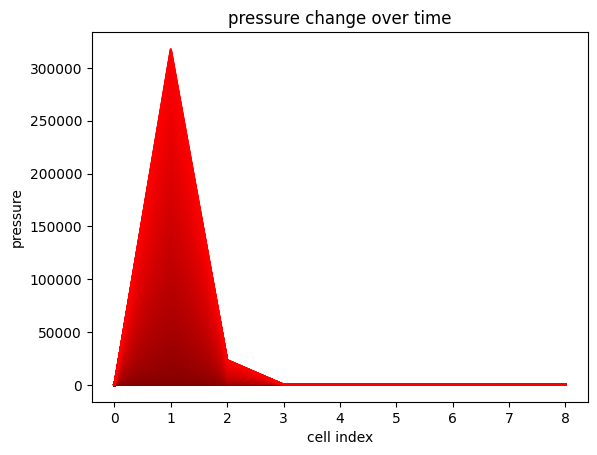

In [293]:
fig, ax = plt.subplots()

ax.set_xlabel("cell index")
ax.set_ylabel("pressure")
ax.set_title("pressure change over time")


for i, vec in enumerate(pressure_vector):
    ax.plot(np.arange(LEN-1), vec, LEN, alpha=0.6, c=(i / len(pressure_vector), 0, 0))

plt.show()

### Generating into video file animation
Make sure the cells above run without errors

MovieWriter ffmpeg unavailable; using Pillow instead.


0


IndexError: list index out of range

0
Error in callback <function _draw_all_if_interactive at 0x000002291438DE40> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'list' object has no attribute 'set_ydata'

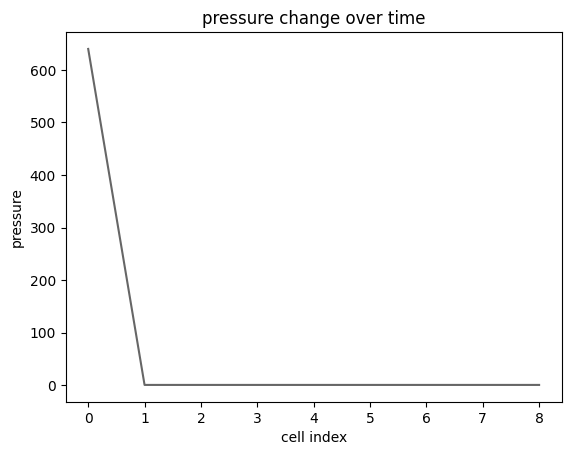

In [307]:
fig, ax = plt.subplots()

ax.set_xlabel("cell index")
ax.set_ylabel("pressure")
ax.set_title("pressure change over time")

l = ax.plot(np.arange(LEN-1), pressure_vector[0], LEN, alpha=0.6, c=(0 / len(pressure_vector), 0, 0))

def update(frame):
    print(frame)
    l.set_ydata(pressure_vector[frame])
    return line

anim = animation.FuncAnimation(fig=fig, func=update, frames=TIME_LEN, interval=1)
anim.save("file")
plt.show()